In [1]:
import sympy as sym
import numpy as np
import scipy as sp
from scipy import linalg,spatial

import matplotlib.pyplot as plt

In [2]:
# podatki
ρ = 2700 #kg/m^3
E = 70e9 #Pa
L = 1 #m

h = 0.030 #m
A = h*h # mm^2
I = h*h**3/12 # mm^4 (pravokoten profil b=h)

In [3]:
# transformacijska matrika
def T(α):
    
    T = np.array([[ np.cos(α), np.sin(α), 0,         0,         0, 0],
                   [-np.sin(α), np.cos(α), 0,         0,         0, 0],
                   [         0,         0, 1,         0,         0, 0],
                   [         0,         0, 0, np.cos(α), np.sin(α), 0],
                   [         0,         0, 0,-np.sin(α), np.cos(α), 0],
                   [         0,         0, 0,         0,         0, 1]])
        
    return T

In [4]:
# masna matrika
def M_e(A, L, ρ, α): #pazi vrstni red vpisa

    M_lok = ρ*A*L*np.array([[1/3,         0,         0, 1/6,         0,         0],
                            [  0,     13/35,  11*L/210,   0,      9/70, -13*L/420],
                            [  0,  11*L/210,  L**2/105,   0,  13*L/420, -L**2/140],
                            [1/6,         0,         0, 1/3,         0,         0],
                            [  0,      9/70,  13*L/420,   0,     13/35, -11*L/210],
                            [  0, -13*L/420, -L**2/140,   0, -11*L/210,  L**2/105]])
    
    return T(α).T @ M_lok @ T(α) #pomnožimo z leve in desne z rotacjsko in je ok

In [5]:
# togostna matrika
def K_e(A, E, I, L, α):

    K_lok = E/L*np.array([[ A,          0,      0, -A,          0,      0],
                          [ 0,  12*I/L**2,  6*I/L,  0, -12*I/L**2,  6*I/L],
                          [ 0,      6*I/L,    4*I,  0,     -6*I/L,    2*I],
                          [-A,          0,      0,  A,          0,      0],
                          [ 0, -12*I/L**2, -6*I/L,  0,  12*I/L**2, -6*I/L],
                          [ 0,      6*I/L,    2*I,  0,     -6*I/L,    4*I]])
    
    return T(α).T @ K_lok @ T(α)

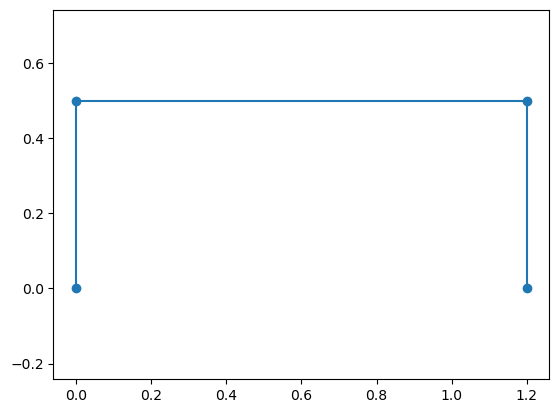

In [6]:
# vozlišča in elementi
%matplotlib inline
a = 1.2*L #širina
b = 0.5*L #višina
vozlisca = np.array([[0,0],[0,b],[a,b],[a,0]])
elementi = np.array([[0,1],[1,2],[2,3]])

[plt.plot(vozlisca[[i,j],0],vozlisca[[i,j],1],'-',c='C0') for i,j in elementi]
plt.plot(vozlisca[:,0],vozlisca[:,1],'o');
plt.axis('equal');

In [7]:
# zgostitev mreže
n=10
vozlišca_AB=np.array([[0,y] for y in np.linspace(0,b,n)])
vozlišca_BC=np.array([[x,b] for x in np.linspace(0,a,n)])
vozlišca_CD=np.array([[a,y] for y in np.linspace(b,0,n)])

#seštejemo vozlišča

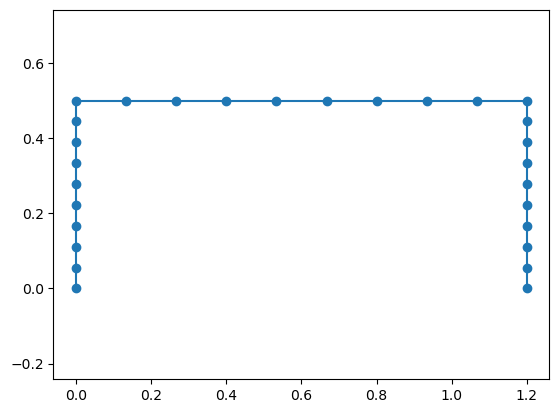

In [8]:
vozlisca = np.vstack([vozlišca_AB,vozlišca_BC[1:],vozlišca_CD[1:]])

elementi = np.array([[i,i+1] for i in range(len(vozlisca)-1) ])  #vsi elementi zaporedoma

[plt.plot(vozlisca[[i,j],0],vozlisca[[i,j],1],'-',c='C0') for i,j in elementi]
plt.plot(vozlisca[:,0],vozlisca[:,1],'o');
plt.axis('equal');

In [9]:
# sestav globalne masne in togostne matrike
M_glob = np.zeros((vozlisca.shape[0]*3,vozlisca.shape[0]*3)) #gledaš št vozlišč in krat 3, ker so po tri prostostne stopnje
K_glob = np.zeros((vozlisca.shape[0]*3,vozlisca.shape[0]*3))

for element in elementi:
    # dolžina elementa
    Le = sp.spatial.distance.euclidean(vozlisca[element[0]], vozlisca[element[1]])
    #Le = np.linalg.norm(vozlisca[element])
    
    # kot zasuka
    αe = np.arctan2(np.diff(vozlisca[element,1]) , np.diff(vozlisca[element,0]))[0]
    
    # indeksi prostostnih stopenj
    ind = np.array([3*element[0],3*element[0]+1,3*element[0]+2,3*element[1],3*element[1]+1,3*element[1]+2])
    
    # priševanje prispevkov posameznih elementov
    M_glob[ind[:,None],ind] += M_e(A, Le, ρ, αe)  #:None za menja vse stolpce v vsaki vrstici, None ti vsakič vzame po 
    K_glob[ind[:,None],ind] += K_e(A, E, I, Le, αe)
    
M_glob.shape

(84, 84)

In [13]:
ind_vpetih_ps = np.array([1, 2, -1])

In [14]:
# tvorimo matriko C
C = np.zeros((len(ind_vpetih_ps),vozlisca.shape[0]*3))
C[[np.arange(len(ind_vpetih_ps))],ind_vpetih_ps]=1  #zmeče na prave indekse vrst in stolpcov
C

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.

In [15]:
# ROBNI POGOJI
ind_vpetih_ps = np.array([0,1,2,-2])

# tvorimo matriko C
C = np.zeros((len(ind_vpetih_ps),vozlisca.shape[0]*3))
C[[0,1,2,3],[0,1,2,-2]]=1

L = sp.linalg.null_space(C)

M_glob_rp = L.T @ M_glob @ L
K_glob_rp = L.T @ K_glob @ L

M_glob.shape

(84, 84)

In [16]:
# lastne vrednosti in lastni vektorji
eig_val, eig_vec = sp.linalg.eig(K_glob_rp, M_glob_rp)

# urejanje po velikosti
_ind = np.argsort(np.abs(eig_val))
eig_val = eig_val[_ind]
eig_vec = eig_vec[:,_ind]
eig_vec = L @ eig_vec

eig_freq = np.abs(eig_val)**0.5 / 2 / np.pi

In [17]:
# lastne frekvence [Hz]
eig_freq[:4].round(1)

array([ 26.8,  60. ,  96.6, 239. ])

In [18]:
eig_vec.shape #prva tolko ko imamo stopenj, drugo to kar je fraj

(84, 80)

### Izris

In [19]:
m = 1
s = 3

pomiki_x = eig_vec[0::3,m] #gre od 0 do konca in vsakega 3, to bojo x-pomiki
pomiki_y = eig_vec[1::3,m]

def_vozlisca = np.copy(vozlisca)
def_vozlisca[:,0] += pomiki_x *s
def_vozlisca[:,1] += pomiki_y * s

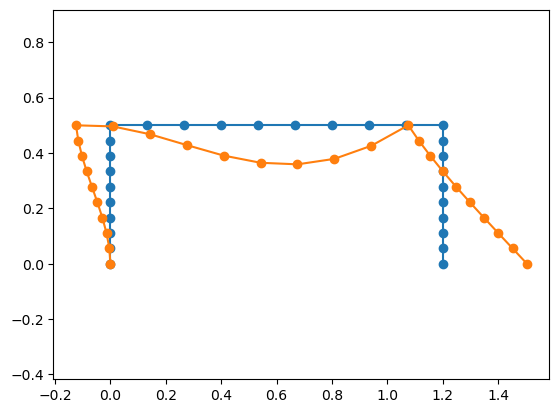

In [20]:
%matplotlib inline
# nedeformirana geometrija
[plt.plot(vozlisca[[i,j],0],vozlisca[[i,j],1],'-',c='C0') for i,j in elementi]
plt.plot(vozlisca[:,0],vozlisca[:,1],'o');
# deformirana geometrija
[plt.plot(def_vozlisca[[i,j],0],def_vozlisca[[i,j],1],'-',c='C1') for i,j in elementi]
plt.plot(def_vozlisca[:,0],def_vozlisca[:,1],'o');
plt.axis('equal');

In [ ]:
%matplotlib qt
import matplotlib.animation as animation




amp = np.linspace(-1,1,25)
amp = np.block([amp,amp[::-1]])
amp = np.tile(amp,20)

fig,ax = plt.subplots()
def animate(i):
    ax.set_xlim(-0.2*a,1.8*a)
    ax.set_ylim(-0.2*b,1.2*b)
    
    pomiki_x = eig_vec[0::3,m]
    pomiki_y = eig_vec[1::3,m]

    def_vozlisca = np.copy(vozlisca)
    def_vozlisca[:,0] += pomiki_x * s * amp[i]
    def_vozlisca[:,1] += pomiki_y * s * amp[i]
       
    return ax.plot(def_vozlisca[:,0],def_vozlisca[:,1],'-o',c='C0')

ani = animation.FuncAnimation(
    fig, animate, interval=5, blit=True, save_count=50)

plt.show()